# Airbnb Analysis: Performance Drivers and Geographic Insights

For this project, I chose to explore the 2024 New York City Airbnb dataset. My analysis was guided by two key questions that aim to uncover the underlying factors contributing to a listing's success.

**Main Question:**  
What variables seem most strongly correlated with the outcome of interest? → What factors drive higher ratings or revenue for Airbnb listings?

**Supporting Question:**  
Which locations show unusual activity or performance? → Do certain neighborhoods consistently outperform others?

I selected the Airbnb dataset because it provides rich features that allow for an in-depth exploration of how factors like trust and sentiment translate into measurable success. I chose this specific context because the dynamics of a successful host-guest relationship are very similar to those of a successful expert-client relationship, which is fundamental to Warmer's mission.

## Setup

I worked in Python 3.12.1 (Anaconda) inside Jupyter Notebook.  
Packages I used include:

- **Data wrangling**: `pandas` (2.2.1), `numpy` (1.26.4)  
- **Visualization**: `matplotlib` (3.8.4), `seaborn` (0.13.2), `folium` (0.20.0)  
- **Statistics & ML**: `scipy` (1.13.0), `scikit-learn` (1.4.2)  
- **Geospatial**: `geopandas` (1.1.1)  
- **Text & sentiment**: `nltk` (3.8.1, VADER lexicon)  
- **Utilities**: `tqdm` (4.67.1) for progress bars  

The data comes from [Inside Airbnb](http://insideairbnb.com/get-the-data/).  
I downloaded the compressed `.gz` files and unzipped them in the terminal before starting the notebook, for example:

```bash
gzip -d calendar.csv.gz

In [283]:
#pip install pandas numpy matplotlib seaborn scipy scikit-learn folium geopandas tqdm nltk
#remove hashtag to install packages in a clean notebook

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, chi2_contingency
import warnings
import re
import ast
from collections import Counter
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import folium
from folium.plugins import HeatMap
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### Data Exploring

In [6]:
listings = pd.read_csv('listings_detailed.csv')
reviews = pd.read_csv('reviews_detailed.csv')

In [7]:
listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,https://www.airbnb.com/rooms/2539,20250617032754,2025-06-17,city scrape,Superfast Wi-Fi. Clean & quiet home by the park,"Bright, serene room in a renovated apartment h...",Close to Prospect Park and Historic Ditmas Park,https://a0.muscache.com/pictures/hosting/Hosti...,2787,...,5.0,4.75,4.88,NaN,f,6,1,5,0,0.08
1,2595,https://www.airbnb.com/rooms/2595,20250617032754,2025-06-17,city scrape,Skylit Midtown Manhattan Spacious Studio,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/hosting/Hosti...,2845,...,4.8,4.81,4.40,NaN,f,3,3,0,0,0.26
2,5136,https://www.airbnb.com/rooms/5136,20250617032754,2025-06-17,city scrape,Spacious Family Friendly Duplex w/ Patio + Yard,"We welcome you to stay in our lovely 2 br, 130...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,7378,...,5.0,4.75,4.75,NaN,t,1,1,0,0,0.03
3,6848,https://www.airbnb.com/rooms/6848,20250617032754,2025-06-17,city scrape,Only 2 stops to Manhattan studio,Comfortable studio apartment with super comfor...,NaN,https://a0.muscache.com/pictures/e4f031a7-f146...,15991,...,4.8,4.69,4.58,NaN,f,1,1,0,0,1.00
4,6872,https://www.airbnb.com/rooms/6872,20250617032754,2025-06-17,previous scrape,Uptown Sanctuary w/ Private Bath (Month to Month),This charming distancing-friendly month-to-mon...,This sweet Harlem sanctuary is a 10-20 minute ...,https://a0.muscache.com/pictures/miso/Hosting-...,16104,...,5.0,5.00,5.00,NaN,f,2,0,2,0,0.03


In [8]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2539,55688172,2015-12-04,25160947,Peter,Great host
1,2539,97474898,2016-08-27,91513326,Liz,Nice room for the price. Great neighborhood. J...
2,2539,105340344,2016-10-01,90022459,Евгений,Very nice apt. New remodeled.
3,2539,133131670,2017-02-20,116165195,George,Great place to stay for a while. John is a gre...
4,2539,138349776,2017-03-19,118432644,Carlos,.


In [9]:
listings.info()
listings.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36322 entries, 0 to 36321
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            36322 non-null  int64  
 1   listing_url                                   36322 non-null  object 
 2   scrape_id                                     36322 non-null  int64  
 3   last_scraped                                  36322 non-null  object 
 4   source                                        36322 non-null  object 
 5   name                                          36320 non-null  object 
 6   description                                   35374 non-null  object 
 7   neighborhood_overview                         19084 non-null  object 
 8   picture_url                                   36322 non-null  object 
 9   host_id                                       36322 non-null 

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,3.632200e+04,36322,3.632200e+04,36322,36322,36320,35374,19084,36322,3.632200e+04,...,25165.000000,25154.000000,25155.000000,5329,36322,36322.000000,36322.000000,36322.000000,36322.000000,25171.000000
unique,NaN,36322,NaN,2,2,34732,30167,14438,35577,NaN,...,NaN,NaN,NaN,1963,2,NaN,NaN,NaN,NaN,NaN
top,NaN,https://www.airbnb.com/rooms/2539,NaN,2025-06-17,city scrape,Water View King Bed Hotel Room,Keep it simple at this peaceful and centrally-...,This furnished apartment is located in Midtown...,https://a0.muscache.com/pictures/6998e77e-4564...,NaN,...,NaN,NaN,NaN,Exempt,f,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,33318,21690,30,93,88,35,NaN,...,NaN,NaN,NaN,3052,29114,NaN,NaN,NaN,NaN,NaN
mean,4.382216e+17,NaN,2.025062e+13,NaN,NaN,NaN,NaN,NaN,NaN,1.713590e+08,...,4.824200,4.744684,4.640968,NaN,NaN,60.704146,41.298001,18.542922,0.033175,0.817262
std,5.199100e+17,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,1.893709e+08,...,0.415509,0.389568,0.491850,NaN,NaN,195.088360,180.125441,83.457149,0.537184,1.850794
min,2.539000e+03,NaN,2.025062e+13,NaN,NaN,NaN,NaN,NaN,NaN,1.678000e+03,...,0.000000,0.000000,0.000000,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.121091e+07,NaN,2.025062e+13,NaN,NaN,NaN,NaN,NaN,NaN,1.764159e+07,...,4.820000,4.650000,4.530000,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.080000
50%,5.004978e+07,NaN,2.025062e+13,NaN,NaN,NaN,NaN,NaN,NaN,8.336440e+07,...,4.960000,4.850000,4.760000,NaN,NaN,1.000000,1.000000,1.000000,0.000000,0.260000
75%,9.277467e+17,NaN,2.025062e+13,NaN,NaN,NaN,NaN,NaN,NaN,3.036223e+08,...,5.000000,5.000000,4.940000,NaN,NaN,8.000000,2.000000,2.000000,0.000000,0.940000


In [10]:
reviews.info()
reviews.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975356 entries, 0 to 975355
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     975356 non-null  int64 
 1   id             975356 non-null  int64 
 2   date           975356 non-null  object
 3   reviewer_id    975356 non-null  int64 
 4   reviewer_name  975352 non-null  object
 5   comments       975104 non-null  object
dtypes: int64(3), object(3)
memory usage: 44.6+ MB


,listing_id,id,date,reviewer_id,reviewer_name,comments
count,9.753560e+05,9.753560e+05,975356,9.753560e+05,975352,975104
unique,NaN,NaN,5487,NaN,121560,936992
top,NaN,NaN,2023-09-04,NaN,David,.
freq,NaN,NaN,1205,NaN,6865,1197
mean,1.908149e+17,5.401109e+17,NaN,1.672100e+08,NaN,NaN
std,3.636762e+17,5.083914e+17,NaN,1.633851e+08,NaN,NaN
min,2.539000e+03,3.149000e+03,NaN,2.900000e+01,NaN,NaN
25%,1.036537e+07,4.226699e+08,NaN,3.244679e+07,NaN,NaN
50%,2.915869e+07,5.913305e+17,NaN,1.099055e+08,NaN,NaN
75%,5.304525e+07,9.637592e+17,NaN,2.602071e+08,NaN,NaN


In [11]:
print("Listings rows:", len(listings))
print("Reviews rows:", len(reviews))

Listings rows: 36322
Reviews rows: 975356


The listings_detailed.csv file contains detailed information on 36,322 New York City Airbnb listings, while reviews_detailed.csv holds 975,356 individual guest reviews with text comments and dates.

### Data Cleaning

In [14]:
#Checking each file for duplicated data that needs to be removed
listings.duplicated().sum()

0

In [15]:
reviews.duplicated().sum()

0

In [16]:
listings.isnull().sum()

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
source                                              0
                                                ...  
calculated_host_listings_count                      0
calculated_host_listings_count_entire_homes         0
calculated_host_listings_count_private_rooms        0
calculated_host_listings_count_shared_rooms         0
reviews_per_month                               11151
Length: 79, dtype: int64

In [17]:
reviews.isnull().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      4
comments         252
dtype: int64

In reviews, the missing values are minor: reviewer_name (4 rows) and comments (252 rows). These are very small relative to the 975k total reviews, so they won’t affect aggregate analysis. I’ll keep these rows but exclude missing comments when doing text or sentiment analysis.
In listings, the only column with notable missingness is reviews_per_month (11,151 rows). This likely corresponds to listings that have never received a review, so I’ll treat these as “zero reviews”

### Exclusion of Non-Standard Listings

To ensure the analysis reflects the typical short-term rental market and is not skewed by atypical offerings, two key filters were applied to the dataset.

First, listings with a nightly price above `$1,000` were excluded. This is a conservative threshold that aligns with established methodological practices; published studies note that listings priced this high often represent luxury properties or large estates, which are not representative of the core market. While a statistical method like the Interquartile Range (IQR) suggests a lower upper bound of approximately `$478`, the `$1,000` cutoff was chosen to remove clear outliers while retaining a reasonable upper range of premium, yet still characteristic, short-term rentals.

Second, listings permitting stays longer than 365 nights (one year) were removed. Stays of this duration fall under the category of long-term leases, which operate under fundamentally different legal and economic principles than short-term rentals. Although the IQR for this metric can suggest a much higher bound due to common platform placeholder values (e.g., 1125 nights), these listings do not reflect genuine short-term rental activity. A 365-night cap ensures the analysis remains focused on Airbnb's core business of nightly, weekly, and monthly stays.

Source: [Short-term rentals and housing affordability](https://www.tandfonline.com/doi/full/10.1080/02673037.2023.2176829)

**What Is IQR and Why Use It?**

The interquartile range (IQR) is a way to measure the “middle spread” of the data. It looks at the range between the 25th percentile (Q1) and the 75th percentile (Q3), which tells us where the bulk of the data sits. We then use this to spot values that fall far outside the typical range. This matters because extreme values can distort averages and give a misleading picture of the market.

A good way to think about it is like checking grocery bills in a neighborhood. Most families might spend between `$100` and `$250` a week, with a few spending `$300` or `$400`. If one receipt shows `$10,000`, you know that is not a normal grocery trip. The IQR method helps us identify those `$10,000` bills in the data so we can set them aside and focus on the spending patterns that actually reflect typical families.

**Outlier Detection for maximum_nights**

The interquartile range (IQR) method shows that the middle 50% of listings allow between 120 and 1,125 nights, with an IQR of 1,005 nights. Using the standard rule (Q3 + 1.5 × IQR), the upper bound is 2,632.5 nights. However, to align with the business rationale for excluding long-term leases stated above, a practical cutoff of 365 nights was applied.

In [22]:
q1 = listings['maximum_nights'].quantile(0.25)
q3 = listings['maximum_nights'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr

print("Q1:", q1, "Q3:", q3, "IQR:", iqr, "Upper bound (1.5*IQR):", upper)

Q1: 120.0 Q3: 1125.0 IQR: 1005.0 Upper bound (1.5*IQR): 2632.5


**Outlier Detection for price**

In [24]:
# Creating a temporary frame for the IQR before I create a function that cleans the listing for price and maximum nights at the same time
df_iqr = listings[['price', 'maximum_nights']].copy()
df_iqr = df_iqr[df_iqr['maximum_nights'].fillna(0) <= 365]

price_str = df_iqr['price'].astype(str)
price_num = price_str.str.replace(r'[^0-9.]', '', regex=True)
df_iqr['price_clean'] = pd.to_numeric(price_num, errors='coerce')

df_iqr = df_iqr[df_iqr['price_clean'] > 0]

q1 = df_iqr['price_clean'].quantile(0.25)
q3 = df_iqr['price_clean'].quantile(0.75)
iqr = q3 - q1
PRICE_IQR_UPPER = q3 + 1.5 * iqr

print("Q1:", q1, "Q3:", q3, "IQR:", iqr, "Upper bound (1.5*IQR):", PRICE_IQR_UPPER)

Q1: 86.0 Q3: 243.0 IQR: 157.0 Upper bound (1.5*IQR): 478.5


**Cleaning Helper Function**

In [26]:
def clean_listings(listings_df):
    df = listings_df.copy()

    df = df.dropna(subset=['price'])
    df = df[df['price'].astype(str).str.strip() != ""]
    df['price_clean'] = (
        df['price'].astype(str).str.replace(r'[$,]', '', regex=True).astype(float)
    )

    df = df[df['price_clean'] <= 1000]

    df['maximum_nights'] = pd.to_numeric(df['maximum_nights'], errors='coerce')
    df = df[df['maximum_nights'] <= 365]

    return df

df = clean_listings(listings)
print("Original rows:", len(listings))
print("Rows after cleaning:", len(df))
print("Price_clean min/max:", df['price_clean'].min(), df['price_clean'].max())
print("Max of maximum_nights:", df['maximum_nights'].max())

Original rows: 36322
Rows after cleaning: 15505
Price_clean min/max: 8.0 1000.0
Max of maximum_nights: 365


**Sanity Check After Cleaning**

After filtering extreme values, the dataset looks reasonable: the average nightly price is around `$188` with a standard deviation of ~$151, which reflects the wide range of budget to luxury options in New York City. Bedrooms and accommodates remain centered around 1–2 bedrooms and 2–4 guests, confirming the dataset is consistent with expectations.

In [29]:
df[["price_clean", "bedrooms", "accommodates"]].describe()

,price_clean,bedrooms,accommodates
count,15505.000000,15449.000000,15505.000000
mean,188.199291,1.343517,2.786005
std,150.900212,0.957471,1.920874
min,8.000000,0.000000,1.000000
25%,85.000000,1.000000,2.000000
50%,145.000000,1.000000,2.000000
75%,238.000000,2.000000,4.000000
max,1000.000000,9.000000,16.000000


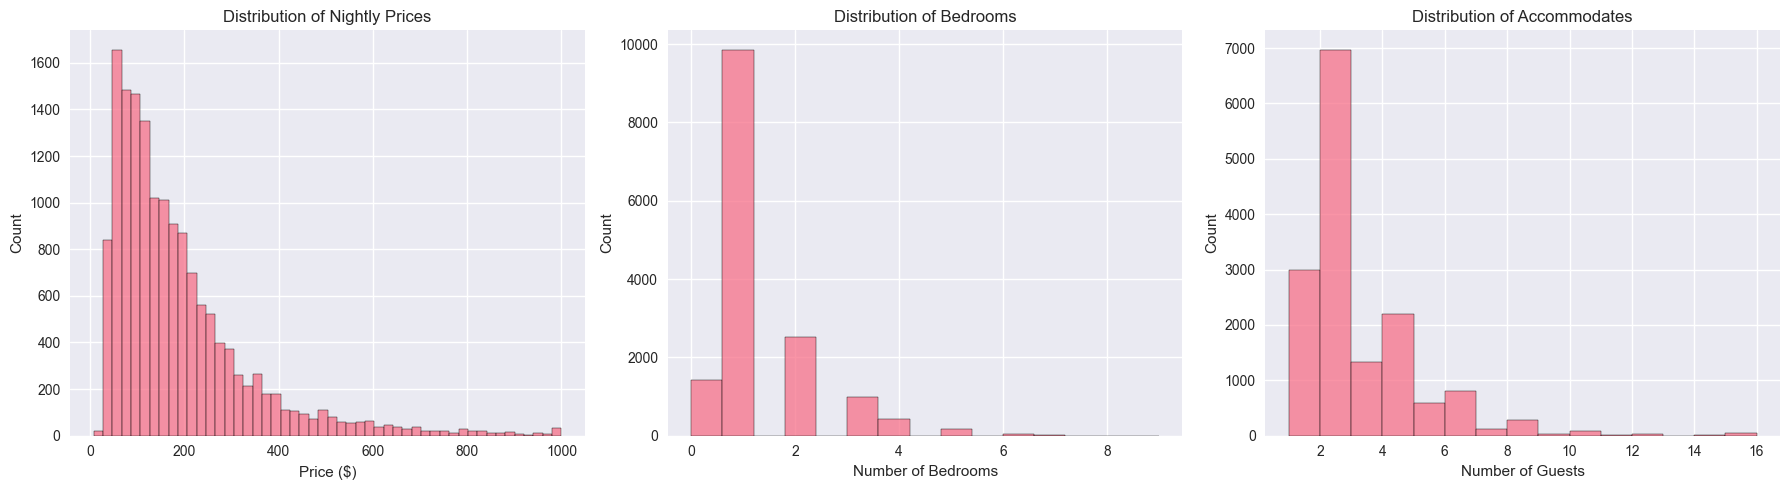

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df["price_clean"], bins=50, ax=axes[0], kde=False)
axes[0].set_title("Distribution of Nightly Prices")
axes[0].set_xlabel("Price ($)")
axes[0].set_ylabel("Count")

sns.histplot(df["bedrooms"], bins=15, ax=axes[1], kde=False)
axes[1].set_title("Distribution of Bedrooms")
axes[1].set_xlabel("Number of Bedrooms")

sns.histplot(df["accommodates"], bins=15, ax=axes[2], kde=False)
axes[2].set_title("Distribution of Accommodates")
axes[2].set_xlabel("Number of Guests")

plt.tight_layout()
plt.show()

### Cleaning Amenities

The amenities column in the Airbnb dataset is stored as long strings that are inconsistent and difficult to analyze. For example, one listing might have `"['Wifi', 'Kitchen']"` while another has `"wifi, kitchen, hair dryer"`.

To make this data usable, I wrote a parsing function that:  
1. Handles missing values by returning an empty list.  
2. Tries to interpret strings formatted like Python lists (e.g., `["Wifi", "Kitchen"]`).  
3. Falls back to splitting on commas if the format is not valid.  
4. Cleans each amenity by removing punctuation, extra spaces, and converting everything to lowercase.  

This process produces a consistent list of amenities for each listing, such as:  
`['wifi', 'kitchen', 'hair dryer']`

Finally, I applied the function across all listings and counted the most common amenities. This allows us to identify which features appear most frequently and later test whether they correlate with higher ratings or revenue.


In [32]:
def parse_amenities(amenities_str):
    if pd.isna(amenities_str):
        return []
    try:
        items = ast.literal_eval(amenities_str)
    except:
        items = amenities_str.split(',')
    
    cleaned = []
    for item in items:
        x = re.sub(r'[^a-zA-Z0-9\s]', '', str(item)).strip().lower()
        cleaned.append(x)
    return cleaned

df['amenities_clean'] = df['amenities'].apply(parse_amenities)

In [33]:
all_amenities = Counter(a for xs in df['amenities_clean'] for a in xs)
top_amenities = [a for a, _ in all_amenities.most_common(20)]

df['amenities_top'] = df['amenities_clean'].apply(
    lambda xs: [a for a in xs if a in top_amenities]
)

mlb = MultiLabelBinarizer(classes=top_amenities)
amenities_encoded = mlb.fit_transform(df['amenities_top'])

cols = [f"amen_{re.sub(r'\\W+', '_', c).strip('_')}" for c in mlb.classes_]
amenities_df = pd.DataFrame(amenities_encoded, columns=cols, index=df.index).astype('uint8')

df = df.drop(columns=[c for c in df.columns if c.startswith('amen_')], errors='ignore')
df = pd.concat([df, amenities_df], axis=1)


counts_top20 = df.filter(like='amen_').sum().sort_values(ascending=False).head(20).astype(int)
pct_top20 = (df.filter(like='amen_').mean() * 100).round(1).reindex(counts_top20.index)

summary_top20 = pd.DataFrame({'count': counts_top20, 'percent': pct_top20})
summary_top20.index = (summary_top20.index
                       .str.replace('amen_', '', regex=False)
                       .str.replace('_', ' ')
                       .str.title())

print(summary_top20.to_string())

                       count  percent
Smoke Alarm            14695     94.8
Wifi                   14443     93.2
Carbon Monoxide Alarm  13308     85.8
Kitchen                13144     84.8
Hot Water              11856     76.5
Hangers                10432     67.3
Air Conditioning       10411     67.1
Essentials             10351     66.8
Dishes And Silverware  10061     64.9
Hair Dryer              9833     63.4
Iron                    9725     62.7
Bed Linens              9722     62.7
Refrigerator            9457     61.0
Dedicated Workspace     9455     61.0
Cooking Basics          9171     59.1
Microwave               9105     58.7
Tv                      8992     58.0
Heating                 8506     54.9
Fire Extinguisher       7942     51.2
Shampoo                 7318     47.2


### What went wrong
**First Attempt**

My first pass at this was to build a simple parser to split the amenities and clean up the punctuation. I figured that would be good enough to get clean categories.

I realized that wasn't working when I took a look at the bottom 20 amenities in the list. The output wasn't actual categories, but a collection of overly specific, un-parsed text. It was full of things like:

    -Tv With Standard Cable Amazon Prime Video Netflix

    -Varies But Tend To Keep It As Natural As Possible Body Soap

    -50 Inch Hdtv With Premium Cable Standard Cable
    
I had to strategize how I would normalize the data after parsing it to improve consistency.

### The New Way

**Second Attempt**

Instead of keeping messy or overly specific entries like “50 inch HDTV with Netflix,” each amenity is cleaned and grouped into a standard label. For example, any kind of TV becomes tv and all Wi-Fi entries become wifi. Additionally, I removed some brand names. This approach makes the data easier to analyze because similar items aren’t scattered across dozens of slightly different names. From here, I got some new categories in my list of top 20 amenities. 'Coffee maker' became a new contender.

In [36]:
def parse_amenities(x):
    if pd.isna(x):
        return []
    if isinstance(x, str) and x.strip().startswith("["):
        try:
            items = ast.literal_eval(x)
        except Exception:
            items = re.split(r",\s*", x)
    else:
        items = re.split(r",\s*", str(x))
    return [i for i in items if i and str(i).strip()]

def normalize_amenity(a):
    s = str(a).lower().strip()
    s = re.sub(r"\b\d+\s*(inch|in|”|mbps|hz|k|p)\b", " ", s)
    s = re.sub(r"[^a-z0-9\s\+]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()

    if re.search(r"(?:\bhdtv\b|\bsmart\s+tv\b|\bfire\s+tv\b|\bapple\s+tv\b|\bchromecast\b|\broku\b|\b(?:hd\s*)?tv\b)", s):
        return "tv"

    if "wifi" in s or "wi fi" in s:
        return "wifi"
    if "kitchen" in s:
        return "kitchen"

    for pat, repl in [
        (r"\bmicrowave\b", "microwave"),
        (r"\brefrigerator|fridge\b", "refrigerator"),
        (r"\boven\b", "oven"),
        (r"\bstove|range\b", "stove"),
        (r"\bdish(?:es)?(?: and)? silverware\b", "dishes and silverware"),
        (r"\bcooking basics?\b", "cooking basics"),
        (r"\bcoffee maker|french press|drip coffee\b", "coffee maker"),
        (r"\bair conditioning|ac\b", "air conditioning"),
        (r"\bheating\b", "heating"),
    ]:
        if re.search(pat, s):
            return repl

    if "shampoo" in s:
        return "shampoo"
    if "conditioner" in s:
        return "conditioner"
    if "body soap" in s or "shower gel" in s or "soap" in s:
        return "body soap"

    if "hair dry" in s:
        return "hair dryer"
    if "bed linen" in s or "linens" in s:
        return "bed linens"
    if "hanger" in s:
        return "hangers"
    if "iron" in s:
        return "iron"

    if "smoke alarm" in s:
        return "smoke alarm"
    if "carbon monoxide" in s:
        return "carbon monoxide alarm"
    if "fire extinguisher" in s:
        return "fire extinguisher"

    if "workspace" in s or "desk" in s:
        return "dedicated workspace"

    if "hot tub" in s:
        return "hot tub"
    if "pool" in s:
        return "pool"
    if "gym" in s:
        return "gym"
    if "parking" in s:
        return "parking"

    if "view" in s:
        if "bay" in s:
            return "view bay"
        if "lake" in s:
            return "view lake"
        if "city" in s:
            return "view city"
        return "view"

    if "essentials" in s:
        return "essentials"
    if "hot water" in s:
        return "hot water"

    return s

**Getting the new top 20 of all amenities**

In [66]:
N = len(df)
top20 = all_amenities.most_common(20)

summary_top20 = (
    pd.DataFrame(top20, columns=["amenity", "count"])
      .assign(percent=lambda d: (d["count"] / N * 100).round(1))
      .set_index("amenity")
      .rename_axis(None)
)

print(summary_top20.to_string())

                       count  percent
smoke alarm            14695     94.8
wifi                   14443     93.2
carbon monoxide alarm  13308     85.8
kitchen                13144     84.8
hot water              11856     76.5
hangers                10432     67.3
air conditioning       10411     67.1
essentials             10351     66.8
dishes and silverware  10061     64.9
hair dryer              9833     63.4
iron                    9725     62.7
bed linens              9722     62.7
refrigerator            9457     61.0
dedicated workspace     9455     61.0
cooking basics          9171     59.1
microwave               9105     58.7
tv                      8992     58.0
heating                 8506     54.9
fire extinguisher       7942     51.2
shampoo                 7318     47.2


**Getting the new band limited bottom 20**

In [76]:
df["amenities_parsed"] = df["amenities"].apply(parse_amenities)
df["amenities_clean"] = df["amenities_parsed"].apply(
    lambda xs: sorted({normalize_amenity(x) for x in xs if normalize_amenity(x)})
)

all_amenities = Counter(a for xs in df["amenities_clean"] for a in xs)
N = len(df)

low, high = 0.01 * N, 0.10 * N
band = {a: c for a, c in all_amenities.items() if low <= c <= high}

top20 = sorted(band.items(), key=lambda x: x[1], reverse=True)[:20]

summary_top20 = (
    pd.DataFrame(top20, columns=["amenity", "count"])
      .assign(percent=lambda d: (d["count"] / N * 100).round(1))
      .set_index("amenity")
      .rename_axis(None)
      .sort_values("count", ascending=False)
)

print(summary_top20.to_string())

                                     count  percent
safe                                  1539      9.9
ethernet connection                   1428      9.2
building staff                        1373      8.9
free dryer in unit                    1313      8.5
ceiling fan                           1284      8.3
drying rack for clothing              1284      8.3
smart lock                            1182      7.6
exercise equipment                    1175      7.6
bbq grill                             1172      7.6
paid dryer in building                1103      7.1
trash compactor                       1076      6.9
paid washer in building               1063      6.9
clothing storage closet and dresser   1047      6.8
window guards                         1043      6.7
private patio or balcony              1019      6.6
board games                           1017      6.6
free washer in unit                    991      6.4
view                                   956      6.2
rice maker  

### Correlating Amenities with Outcomes

After cleaning the amenities, I transformed them into binary columns (1 = amenity present, 0 = not present). To understand whether certain amenities are linked to better performance, I compared them against key outcome variables: revenue, occupancy, ratings, price, and review activity.

Because these outcomes are often skewed (for example, a few listings generate extremely high revenue), I used **pairwise Spearman correlation**, which is better suited for non-normal data. The heatmap below shows which amenities are most strongly associated with higher revenue, occupancy, or ratings.

**What Is Spearman and Why Use It?**

Spearman rank correlation measures how well two variables move in the same order. It converts raw values into ranks, then checks whether high ranks on one variable line up with high ranks on the other. It captures general up-or-down relationships, not only straight-line ones, and it is less sensitive to extreme values. That makes it a good fit when revenue or reviews are skewed by a few very large listings.

                       count  percent
wifi                   15291     98.6
smoke alarm            14695     94.8
air conditioning       14159     91.3
kitchen                13535     87.3
carbon monoxide alarm  13308     85.8
tv                     13040     84.1
heating                12802     82.6
hot water              12051     77.7
refrigerator           10900     70.3
hangers                10432     67.3
essentials             10357     66.8
dishes and silverware  10061     64.9
hair dryer              9833     63.4
iron                    9725     62.7
bed linens              9722     62.7
dedicated workspace     9455     61.0
cooking basics          9171     59.1
microwave               9105     58.7
parking                 8613     55.5
coffee maker            8497     54.8


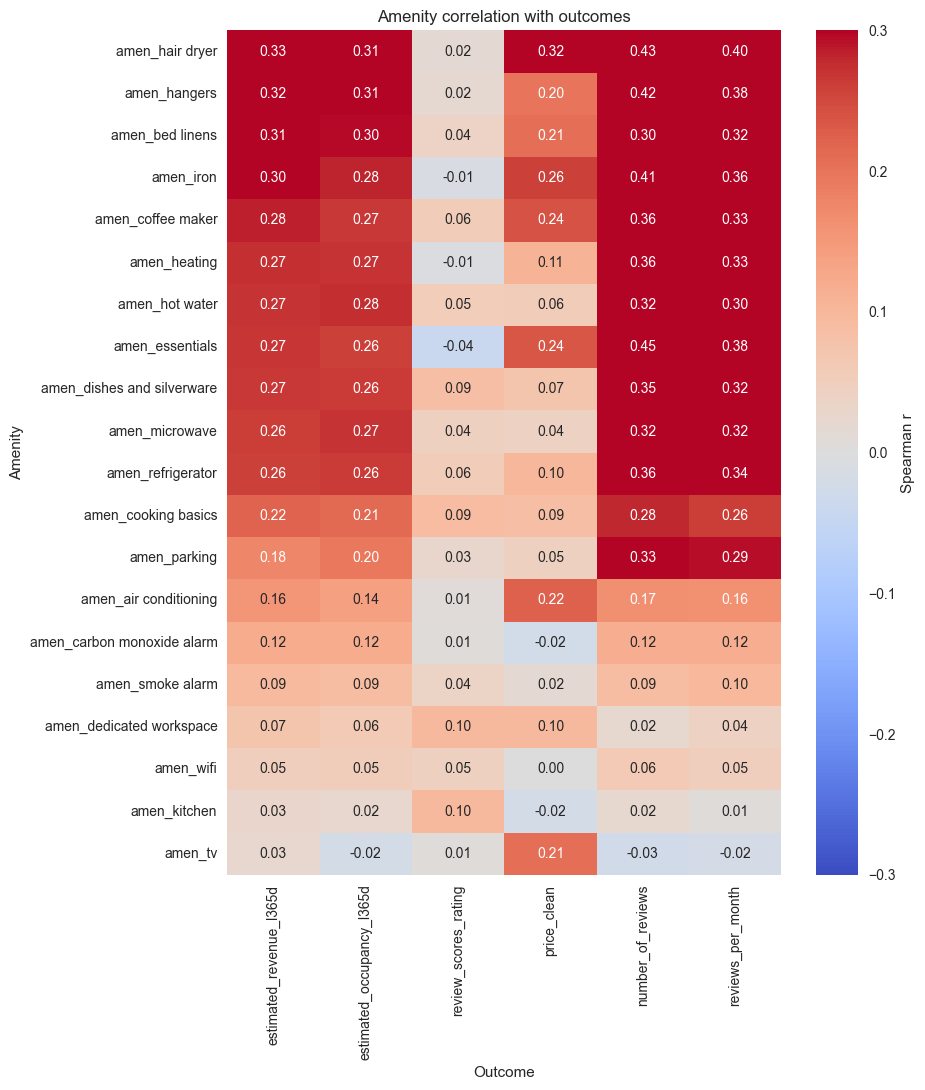

In [72]:
df = df.loc[:, ~df.columns.duplicated()]
# Drop old amen_ columns so we can re-encode from the cleaned amenities list. 
# This avoids duplicates or stale columns and keeps the heatmap aligned with the new top 20.
df = df.drop(columns=[c for c in df.columns if c.startswith("amen_")], errors="ignore")


all_amenities = Counter(a for xs in df["amenities_clean"] for a in set(xs))
top20 = [a for a, _ in all_amenities.most_common(20)]

mlb = MultiLabelBinarizer(classes=top20)
encoded = mlb.fit_transform(
    df["amenities_clean"].apply(lambda xs: [a for a in xs if a in top20])
)
cols = [f"amen_{re.sub(r'\\W+', '_', a).strip('_')}" for a in mlb.classes_]
amen_df = pd.DataFrame(encoded, columns=cols, index=df.index).astype("uint8")
df = pd.concat([df, amen_df], axis=1)

summary_top20 = (
    pd.DataFrame([(a, all_amenities[a]) for a in top20], columns=["amenity", "count"])
      .assign(percent=lambda d: (d["count"]/len(df)*100).round(1))
      .set_index("amenity")
      .rename_axis(None)
      .sort_values("count", ascending=False)
)
print(summary_top20.to_string())

amen_cols = cols

targets = [
    "estimated_revenue_l365d",
    "estimated_occupancy_l365d",
    "review_scores_rating",
    "price_clean",
    "number_of_reviews",
    "reviews_per_month",
]
targets = [c for c in targets if c in df.columns]

sub = df[amen_cols + targets].copy()
sub[targets] = sub[targets].apply(pd.to_numeric, errors="coerce")
if "number_of_reviews" in sub:
    sub["number_of_reviews"] = sub["number_of_reviews"].fillna(0)
    if "reviews_per_month" in sub:
        sub.loc[sub["number_of_reviews"] == 0, "reviews_per_month"] = 0
sub = sub.dropna(subset=targets, how="all")

amen_cols = [c for c in amen_cols if sub[c].nunique() > 1 and sub[c].sum() >= 50]

corr = sub.corr(method="spearman", min_periods=100).loc[amen_cols, targets]
if "estimated_revenue_l365d" in corr:
    corr = corr.reindex(corr["estimated_revenue_l365d"].abs().sort_values(ascending=False).index)

plt.figure(figsize=(0.9*len(targets)+4, 0.35*len(amen_cols)+4))
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-0.3, vmax=0.3, cmap="coolwarm",
            cbar_kws={"label": "Spearman r"})
plt.title("Amenity correlation with outcomes")
plt.xlabel("Outcome")
plt.ylabel("Amenity")
plt.tight_layout()
plt.show()

In [78]:
corr

,estimated_revenue_l365d,estimated_occupancy_l365d,review_scores_rating,price_clean,number_of_reviews,reviews_per_month
amen_hair dryer,0.329640,0.306958,0.016535,0.320452,0.427729,0.399184
amen_hangers,0.315954,0.314538,0.019770,0.201305,0.422589,0.384919
amen_bed linens,0.306267,0.295364,0.038574,0.207455,0.304652,0.321169
amen_iron,0.300180,0.282028,-0.011126,0.259870,0.408700,0.363851
amen_coffee maker,0.284554,0.265432,0.057992,0.240776,0.357294,0.331908
amen_heating,0.274130,0.269848,-0.005059,0.108196,0.359593,0.325232
amen_hot water,0.270282,0.276137,0.054798,0.058059,0.315995,0.298501
amen_essentials,0.267699,0.259361,-0.040996,0.235820,0.453699,0.378656
amen_dishes and silverware,0.266473,0.263427,0.088960,0.072705,0.354651,0.324605
amen_microwave,0.260966,0.269990,0.044834,0.042565,0.317716,0.319127


### Correlating Grouped Amenities
Looking at individual amenities shows which items correlate with revenue, occupancy, and reviews, but many of these overlap (for example, linens, hair dryer, and iron all signal comfort). Grouping them into broader categories makes the patterns easier to see. It shows whether certain types of amenities consistently stand out, highlights bigger themes (comfort vs. safety vs. extras), and keeps us from overemphasizing items that are either too specific or almost universal (like WiFi).

Group prevalence percent:
 connectivity_work     99.0
kitchen_basics        96.2
safety                95.7
extras_lifestyle      92.7
comfort_essentials    86.8 



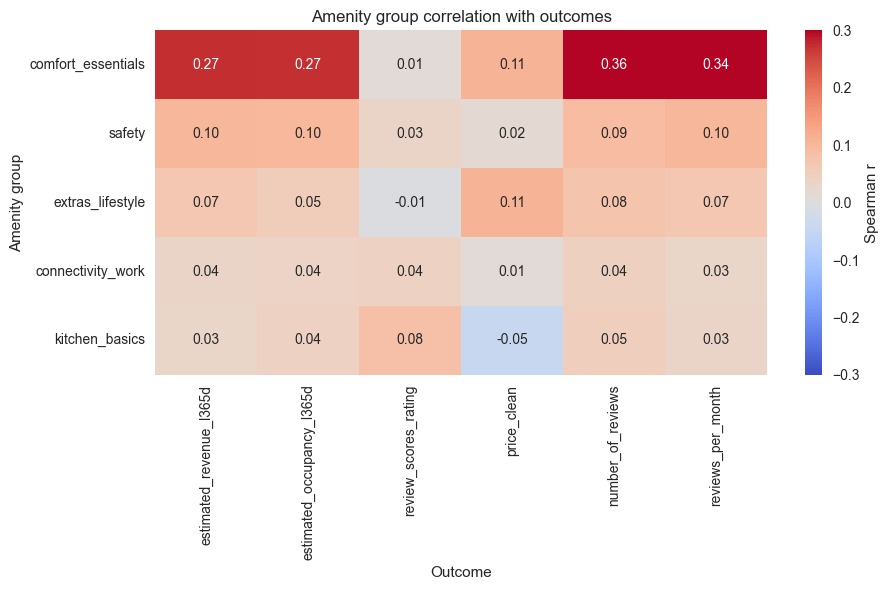

In [80]:
groups = {
    "comfort_essentials": [
        "amen_hair dryer","amen_hangers","amen_bed linens","amen_iron",
        "amen_heating","amen_hot water","amen_essentials"
    ],
    "kitchen_basics": [
        "amen_coffee maker","amen_microwave","amen_refrigerator",
        "amen_dishes and silverware","amen_cooking basics","amen_kitchen"
    ],
    "safety": [
        "amen_smoke alarm","amen_carbon monoxide alarm"
    ],
    "connectivity_work": [
        "amen_wifi","amen_dedicated workspace","amen_ethernet connection"
    ],
    "extras_lifestyle": [
        "amen_tv","amen_board games","amen_bbq grill","amen_exercise equipment","amen_parking"
    ],
}

targets = [
    "estimated_revenue_l365d",
    "estimated_occupancy_l365d",
    "review_scores_rating",
    "price_clean",
    "number_of_reviews",
    "reviews_per_month",
]
targets = [c for c in targets if c in df.columns]

sub = df.copy()
sub[targets] = sub[targets].apply(pd.to_numeric, errors="coerce")
if "number_of_reviews" in sub.columns:
    sub["number_of_reviews"] = sub["number_of_reviews"].fillna(0)
    if "reviews_per_month" in sub.columns:
        sub.loc[sub["number_of_reviews"] == 0, "reviews_per_month"] = 0

for g, cols in groups.items():
    cols_present = [c for c in cols if c in sub.columns]
    if not cols_present:
        sub[g] = 0
        continue
    sub[g] = sub[cols_present].fillna(0).astype("uint8").max(axis=1)

group_prev = (sub[list(groups.keys())].mean() * 100).round(1).sort_values(ascending=False)
print("Group prevalence percent:\n", group_prev.to_string(), "\n")

group_cols = list(groups.keys())
sub2 = sub[group_cols + targets].dropna(subset=targets, how="all")

corr_g = sub2.corr(method="spearman", min_periods=100).loc[group_cols, targets]

if "estimated_revenue_l365d" in corr_g.columns:
    corr_g = corr_g.reindex(corr_g["estimated_revenue_l365d"].abs().sort_values(ascending=False).index)

plt.figure(figsize=(0.9*len(targets)+4, 0.6*len(group_cols)+3))
sns.heatmap(corr_g, annot=True, fmt=".2f", vmin=-0.3, vmax=0.3, cmap="coolwarm",
            cbar_kws={"label": "Spearman r"})
plt.title("Amenity group correlation with outcomes")
plt.xlabel("Outcome")
plt.ylabel("Amenity group")
plt.tight_layout()
plt.show()


In [82]:
corr_g

,estimated_revenue_l365d,estimated_occupancy_l365d,review_scores_rating,price_clean,number_of_reviews,reviews_per_month
comfort_essentials,0.274750,0.272128,0.009423,0.107829,0.364970,0.339100
safety,0.101461,0.099330,0.033606,0.018263,0.092834,0.102289
extras_lifestyle,0.069150,0.053578,-0.006472,0.109548,0.077263,0.070196
connectivity_work,0.035034,0.038295,0.040789,0.009726,0.044959,0.031515
kitchen_basics,0.031212,0.041815,0.083225,-0.045104,0.049873,0.032989


### Interpreting the Heatmap

The heatmap reveals meaningful patterns in how amenities relate to Airbnb performance, though it's important to note that **all correlations are relatively modest.** The strongest reaches only 0.33 out of a possible 1.0, indicating weak to moderate relationships overall.

**The ubiquity effect is clearly at work:** Amenities showing the weakest correlations (WiFi at 0.05, TV at 0.03, and air conditioning at 0.16) are also the most prevalent, found in 98.6%, 84.1%, and 91.3% of listings respectively. When amenities become nearly universal, they lose their ability to differentiate properties since guests simply expect them as baseline features.

**The differentiation sweet spot:** The highest-performing amenities like hair dryers (0.33 correlation) and hangers (0.32) are present in 63-67% of listings. They're common enough to be valued but not so universal that they're taken for granted. This suggests there's still competitive advantage in providing thoughtful basics that many hosts overlook.

**Individual amenities outperform grouped categories:** There's a notable pattern where specific amenities show stronger correlations than their category averages. For instance, while the comfort_essentials group shows a 0.27 revenue correlation, individual items within it like hair dryers (0.33) and hangers (0.32) perform significantly better. Similarly, kitchen_basics as a group correlates weakly with revenue (0.03), yet individual kitchen amenities like dishes and silverware (0.27) and microwaves (0.26) show much stronger relationships.

**This likely reflects methodological considerations rather than guest preferences:** The weaker group correlations may result from how the categories were constructed or measured. Some amenities within groups might be highly correlated with each other, creating redundancy that dilutes the overall group effect. Additionally, guests may not think in terms of amenity categories but rather notice and appreciate specific functional items that solve particular needs during their stay.

## Trust, Sentiment, and Performance

Reviews provide valuable signals about how guests experience a listing. To study how trust and sentiment relate to performance, I created a per-listing sentiment score from guest reviews using VADER. I combined this with key trust features (Superhost status, communication rating, and overall rating) and used log-transformed revenue as the main outcome. I then examined how these factors correlate.

**Building a Sentiment Feature**

To connect guest experience with outcomes, I first pulled in the reviews data and restricted it to listings that survived my earlier cleaning. This ensures that all sentiment scores match the same set of valid listings.

In [215]:
df = df.copy()
df["id"] = pd.to_numeric(df["id"], errors="coerce").astype("Int64")

valid_ids = set(df["id"].dropna().unique())

df_reviews = pd.read_csv("reviews_detailed.csv", usecols=["listing_id","comments"])
df_reviews["listing_id"] = pd.to_numeric(df_reviews["listing_id"], errors="coerce").astype("Int64")

df_reviews = df_reviews[df_reviews["listing_id"].isin(valid_ids)]

print("Listings after cleaning:", df["id"].nunique())
print("Reviews before filtering:", len(pd.read_csv("reviews_detailed.csv", usecols=["listing_id"])))
print("Reviews after filtering:", len(df_reviews))
print("Listings with reviews:", df_reviews["listing_id"].nunique())

Listings after cleaning: 15505
Reviews before filtering: 975356
Reviews after filtering: 521341
Listings with reviews: 10829


**Applying Sentiment Analysis**

Next, I used VADER, a rule-based sentiment analyzer, to score each review comment on a scale from -1 (negative) to +1 (positive). I then averaged the scores at the listing level to produce a single sentiment measure for each property.

**What Is VADER and Why Use It?**

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a tool built for short, conversational text like product or service reviews. It assigns each comment a quick “mood reading” from very negative to very positive. You can think of it like a thermometer for tone: each review provides a temperature check, and averaging across reviews gives the overall climate of guest experience for a listing.

In [218]:
tqdm.pandas()
nltk.download("vader_lexicon", quiet=True)

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if pd.isna(text):
        return np.nan
    s = str(text).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return np.nan
    return sia.polarity_scores(s)["compound"]

I compute a sentiment score for each review, then average by listing to get a single value per listing.

In [226]:
reviews = df_reviews.copy()

reviews = reviews[["listing_id", "comments"]].dropna(subset=["listing_id", "comments"])
reviews["comments"] = reviews["comments"].astype(str).str.strip()
reviews = reviews[reviews["comments"].str.len() > 2]

reviews["listing_id"] = pd.to_numeric(reviews["listing_id"], errors="coerce")
reviews = reviews.dropna(subset=["listing_id"])
reviews["listing_id"] = reviews["listing_id"].astype("Int64")

reviews = reviews.drop_duplicates(subset=["listing_id", "comments"])

reviews["sentiment"] = reviews["comments"].progress_apply(get_sentiment)

print("Review rows after cleaning:", len(reviews))
print("Non-null sentiment rows:", reviews["sentiment"].notna().sum())
display(reviews[["listing_id","comments","sentiment"]].head(5))

  0%|          | 0/518503 [00:00<?, ?it/s]

Review rows after cleaning: 518503
Non-null sentiment rows: 518500


,listing_id,comments,sentiment
62,6848,Stayed with Allen and Irina about a year ago. ...,0.9230
63,6848,Irina was very welcoming and the apt was comfo...,0.9562
64,6848,This apartment was perfect for our stay in NY ...,0.9637
65,6848,Allen and Irena were simply wonderful hosts an...,0.9756
66,6848,It's everything Mike M said & more. Allen & Ir...,0.9679


I map the per-listing sentiment back to the listings table, then check coverage.

In [228]:
sentiment_by_listing = (
    reviews.groupby("listing_id", as_index=False, dropna=True)["sentiment"]
           .mean()
           .rename(columns={"sentiment": "sentiment_mean"})
)

df = df.copy()
df["id"] = pd.to_numeric(df["id"], errors="coerce")
df = df.dropna(subset=["id"])
df["id"] = df["id"].astype("Int64")

sent_map = dict(zip(sentiment_by_listing["listing_id"], sentiment_by_listing["sentiment_mean"]))
df["sentiment"] = df["id"].map(sent_map)

print("Listings total:", df["id"].nunique())
print("Listings with sentiment:", df["sentiment"].notna().sum())
display(df[["id","sentiment"]].head(5))

print("Sample df ids:", df["id"].dropna().astype(str).head(5).tolist())
print("Sample review ids:", sentiment_by_listing["listing_id"].dropna().astype(str).head(5).tolist())

Listings total: 15505
Listings with sentiment: 10823


,id,sentiment
3,6848,0.755078
5,6990,0.854300
11,60611,0.738759
17,7801,0.934423
20,158061,0.885889


Sample df ids: ['6848', '6990', '60611', '7801', '158061']
Sample review ids: ['6848', '6990', '7801', '9357', '12937']


With sentiment attached, I compare it to trust features and performance. Revenue is skewed, so I use log(revenue + 1) and Spearman rank correlation.

In [233]:
cols = [
    "host_is_superhost",
    "review_scores_communication",
    "sentiment",
    "review_scores_rating",
    "estimated_revenue_l365d",
]
tmp = df[cols].copy()

tmp["host_is_superhost"] = (
    tmp["host_is_superhost"]
      .replace({True: 1, False: 0, "t": 1, "f": 0, 1.0: 1, 0.0: 0})
      .astype("float64")
)

tmp["estimated_revenue_l365d"] = pd.to_numeric(tmp["estimated_revenue_l365d"], errors="coerce")
tmp.loc[tmp["estimated_revenue_l365d"] <= 0, "estimated_revenue_l365d"] = np.nan
tmp["log_revenue"] = np.log1p(tmp["estimated_revenue_l365d"])

use_cols = ["host_is_superhost", "review_scores_communication", "sentiment",
            "review_scores_rating", "log_revenue"]

sub = tmp[use_cols].dropna(how="any")
print("Rows available for correlation (strict):", len(sub))

Rows available for correlation (strict): 7273


                             host_is_superhost  review_scores_communication  \
host_is_superhost                         1.00                         0.22   
review_scores_communication               0.22                         1.00   
sentiment                                 0.18                         0.47   
review_scores_rating                      0.28                         0.73   
log_revenue                               0.22                        -0.11   

                             sentiment  review_scores_rating  log_revenue  
host_is_superhost                 0.18                  0.28         0.22  
review_scores_communication       0.47                  0.73        -0.11  
sentiment                         1.00                  0.50        -0.02  
review_scores_rating              0.50                  1.00        -0.06  
log_revenue                      -0.02                 -0.06         1.00  


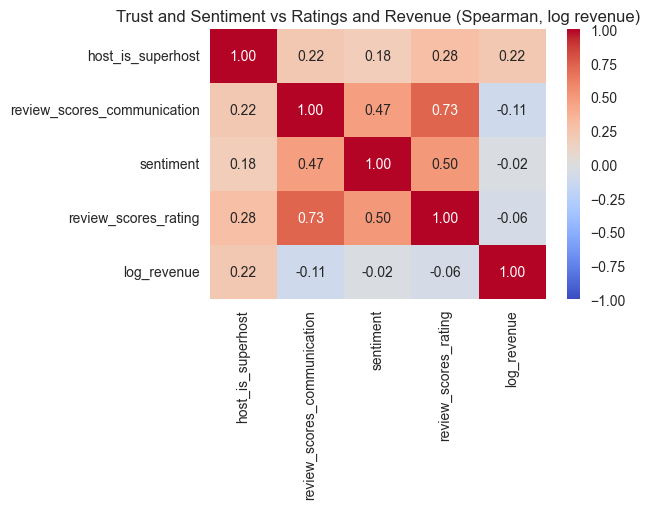

In [235]:
corr = sub.corr(method="spearman")
print(corr.round(2))

plt.figure(figsize=(6.5, 5.2))
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Trust and Sentiment vs Ratings and Revenue (Spearman, log revenue)")
plt.tight_layout()
plt.show()

In [237]:
corr

,host_is_superhost,review_scores_communication,sentiment,review_scores_rating,log_revenue
host_is_superhost,1.000000,0.224908,0.181979,0.282115,0.224671
review_scores_communication,0.224908,1.000000,0.473988,0.729135,-0.106919
sentiment,0.181979,0.473988,1.000000,0.504792,-0.024073
review_scores_rating,0.282115,0.729135,0.504792,1.000000,-0.064903
log_revenue,0.224671,-0.106919,-0.024073,-0.064903,1.000000


### Interpreting the Trust and Performance Matrix

Correlations are mostly weak to moderate. The strongest relationship is between communication and overall ratings `(ρ = 0.73)`, which is meaningful but not deterministic.

**Communication is the foundation of guest satisfaction.**  
Communication aligns strongly with overall ratings `(ρ = 0.73)` and relates to review sentiment `(ρ = 0.47)`. This suggests that being responsive and clear improves both star ratings and the tone of written feedback.

**Superhost status is a consistent quality signal.**  
Superhost status correlates with communication `(ρ = 0.22)`, overall ratings `(ρ = 0.28)`, and revenue in log terms (`(ρ = 0.22)`). This implies that recognized hosts tend to communicate better, earn higher ratings, and generate more revenue.

**The revenue–quality paradox shows up again.**  
Review-related metrics have small negative relationships with log revenue: communication `(ρ = -0.11)`, ratings `(ρ = -0.06)`, and sentiment (`(ρ = -0.02)`). High revenue does not track with better reviews, which supports the idea that revenue can be driven by factors like location or demand even when guest satisfaction is typical.

**Sentiment adds signal but is not dominant.**  
Sentiment correlates with ratings `(ρ = 0.50)` and communication `(ρ = 0.47)`, indicating that the emotional tone of reviews generally matches how guests rate their stay and how they experienced host responsiveness.

**Putting it together.**  
Communication stands out as the clearest lever for improving guest-perceived quality, recognition aligns with better outcomes across the board, and revenue behaves somewhat independently of review quality.

### Neighborhood Hotspots and Coldspots
To explore this further, I examined revenue patterns at the neighborhood level. Location is often suspected to be a major driver of Airbnb performance, but to confirm this I aggregated listings by neighborhood. For each neighborhood, I calculated the number of listings, average and median revenue, and average ratings, filtering out areas with too few listings to be reliable. This lets us see whether certain neighborhoods consistently stand out as “hotspots” or “coldspots” in terms of revenue and satisfaction.

### Data Exploring

In [242]:
rev_col = 'estimated_revenue_l365d'
df[rev_col] = pd.to_numeric(df[rev_col], errors='coerce')
df.loc[df[rev_col] <= 0, rev_col] = pd.NA

geo = (df.groupby('neighbourhood_cleansed', dropna=True)
         .agg(listing_count=('id','nunique'),
              avg_revenue=(rev_col,'mean'),
              avg_rating=('review_scores_rating','mean'))
         .reset_index())

print(geo.shape)
geo.head()

(216, 4)


,neighbourhood_cleansed,listing_count,avg_revenue,avg_rating
0,Allerton,22,14430.000000,4.864167
1,Arrochar,10,19158.400000,4.852857
2,Arverne,41,14651.187500,4.820645
3,Astoria,194,27112.641509,4.783846
4,Bath Beach,23,27469.230769,4.854706


In [244]:
print("Total listings across neighborhoods:", geo['listing_count'].sum())
print("Unique neighborhoods:", geo['neighbourhood_cleansed'].nunique())

Total listings across neighborhoods: 15505
Unique neighborhoods: 216


### Data Cleaning
If a neighborhood has only a few listings, its average revenue can swing a lot due to one outlier. To keep results stable, I analyze neighborhoods with at least 20 listings. To justify the 20-listing minimum, I look at the distribution of listing counts by neighborhood.

Text(0, 0.5, 'Number of neighborhoods')

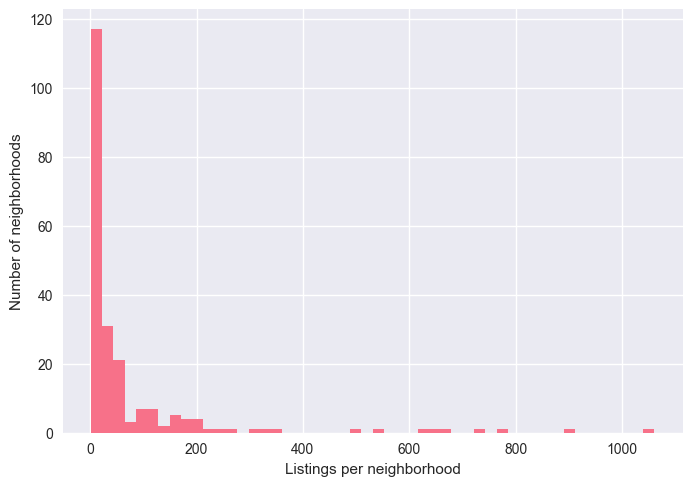

In [247]:
ax = geo['listing_count'].hist(bins=50)
ax.set_xlabel("Listings per neighborhood")
ax.set_ylabel("Number of neighborhoods")

In [249]:
min_listings = 20
geo_filtered = geo[geo["listing_count"] >= min_listings].copy()

coverage = geo_filtered["listing_count"].sum() / df["id"].nunique()
print(f"Neighborhoods kept: {len(geo_filtered)} of {len(geo)}")
print(f"Listings retained: {coverage:.1%} of all listings")
print("Dropped neighborhoods:", (geo["listing_count"] < min_listings).sum())

Neighborhoods kept: 105 of 216
Listings retained: 94.6% of all listings
Dropped neighborhoods: 111


I summarize revenue and ratings across the filtered neighborhoods, then scan top and bottom areas.

In [252]:
print("Mean neighborhood avg revenue:", geo_filtered["avg_revenue"].mean())
print("Median neighborhood avg revenue:", geo_filtered["avg_revenue"].median())
print("Mean neighborhood avg rating:", geo_filtered["avg_rating"].mean())
print("Median neighborhood avg rating:", geo_filtered["avg_rating"].median())

Mean neighborhood avg revenue: 26961.067860487732
Median neighborhood avg revenue: 25021.16
Mean neighborhood avg rating: 4.745832710105429
Median neighborhood avg rating: 4.762


To see how neighborhoods compare, I list the top and bottom performers by average revenue. This highlights which areas consistently stand out as revenue hotspots or coldspots I also check top neighborhoods by guest ratings, alongside those with the largest number of listings. This provides context on whether scale or satisfaction aligns with financial performance.

In [255]:
print("Top 5 by avg revenue:\n", geo_filtered.sort_values("avg_revenue", ascending=False).head(5))
print("Bottom 5 by avg revenue:\n", geo_filtered.sort_values("avg_revenue").head(5))

print("Top 5 by avg rating:\n", geo_filtered.sort_values("avg_rating", ascending=False).head(5))
print("Most listings (scale check):\n", geo_filtered.sort_values("listing_count", ascending=False).head(5))

Top 5 by avg revenue:
     neighbourhood_cleansed  listing_count   avg_revenue  avg_rating
92       Greenwich Village             52  67467.105263    4.833793
187       Theater District            154  57287.849315    4.654118
73      Financial District            200  52375.819149    4.756930
174                   SoHo             87  50773.489362    4.757869
212        Windsor Terrace             39  48921.666667    4.903871
Bottom 5 by avg revenue:
     neighbourhood_cleansed  listing_count   avg_revenue  avg_rating
188            Throgs Neck             20   7375.000000    4.745000
111            Kingsbridge             30   7538.666667    4.546190
209         Williamsbridge             28   8332.888889    4.790000
66                Edenwald             23   8979.666667    4.850769
130    Morningside Heights             47  10544.642857    4.348800
Top 5 by avg rating:
     neighbourhood_cleansed  listing_count   avg_revenue  avg_rating
43           College Point             34  28

In [257]:
q1, q3 = geo_filtered["avg_revenue"].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr

geo_filtered["rev_outlier"] = np.select(
    [geo_filtered["avg_revenue"] < lower, geo_filtered["avg_revenue"] > upper],
    ["low", "high"],
    default="typical"
)

geo_filtered["rev_outlier"].value_counts()

rev_outlier
typical    102
high         3
Name: count, dtype: int64

Using the interquartile range (IQR) rule, I flagged revenue outliers at the neighborhood level. Out of 105 neighborhoods, 3 were tagged as unusually high-revenue “hotspots,” while none were unusually low. I kept these outliers in the correlation step, and the relationship between average revenue and average ratings stayed essentially flat (≈0). This suggests that extreme neighborhoods do not meaningfully change the overall pattern.

In [260]:
corr_neigh = geo_filtered[["avg_revenue", "avg_rating"]].corr(method="spearman")
print(corr_neigh)

             avg_revenue  avg_rating
avg_revenue     1.000000    0.001037
avg_rating      0.001037    1.000000


### Hotspot and Coldsport Results

When looking at revenue by neighborhood (n ≥ 20 listings), a few clear patterns emerge:

- **Hotspots**: Greenwich Village, Theater District, and the Financial District stand out, with average revenues between `$52k–\$67k`. These were also flagged as statistical outliers, confirming they are unusually high compared to the city overall. SoHo and Windsor Terrace also rank in the top 5, though they are within the expected range.
- **Coldspots**: Throgs Neck, Kingsbridge, Williamsbridge, Edenwald, and Morningside Heights fall at the bottom, with average revenues below `$11k`. While these are not statistical outliers, they consistently underperform relative to the city median.

This confirms that revenue potential is unevenly distributed across New York City, with a handful of neighborhoods pulling far ahead.

### Exploring Amenity Importance by Neighborhood

So far, we have looked at amenities across the entire dataset. To understand whether certain amenities matter more in specific neighborhoods, we calculate the correlation between each amenity and revenue within each neighborhood.

In [264]:
neigh_results = []
min_listings = 50  

for neigh, g in df.groupby("neighbourhood_cleansed"):
    if len(g) < min_listings:
        continue
    corr = g[amen_cols + targets].corr(method="spearman").loc[amen_cols, ["estimated_revenue_l365d"]]
    corr = corr["estimated_revenue_l365d"].sort_values(ascending=False)
    top_amenity = corr.index[0]
    top_corr = corr.iloc[0]
    neigh_results.append((neigh, top_amenity, top_corr, len(g)))

neigh_df = pd.DataFrame(neigh_results, columns=["Neighborhood", "Top Amenity", "Correlation", "N"])

neigh_df_filtered = neigh_df[neigh_df["N"] >= 50].copy()

neigh_df_filtered["Prevalence"] = neigh_df_filtered.apply(
    lambda row: df.loc[df["neighbourhood_cleansed"] == row["Neighborhood"], row["Top Amenity"]].mean(),
    axis=1
)

neigh_df_filtered.sort_values("Correlation", ascending=False).head(10)

,Neighborhood,Top Amenity,Correlation,N,Prevalence
33,Little Italy,amen_hair dryer,0.777648,55,0.345455
39,Ozone Park,amen_coffee maker,0.697159,50,0.400000
43,Richmond Hill,amen_microwave,0.587190,57,0.596491
44,Ridgewood,amen_coffee maker,0.586530,190,0.342105
59,Woodhaven,amen_air conditioning,0.554796,50,0.860000
25,Gramercy,amen_refrigerator,0.553254,99,0.666667
23,Fort Greene,amen_iron,0.541401,103,0.582524
29,Hell's Kitchen,amen_hair dryer,0.537518,765,0.562092
7,Chelsea,amen_essentials,0.520103,351,0.618234
19,Financial District,amen_parking,0.512828,200,0.475000


In [266]:
# Checking prevelance of amenity in Theater District for example
neigh = "Theater District"
amen = "amen_hair dryer"

prevalence = (
    df.loc[df['neighbourhood_cleansed'] == neigh, amen]
    .mean()
)

print(f"{amen} prevalence in {neigh}: {prevalence:.2%}")

amen_hair dryer prevalence in Theater District: 95.45%


### Amenity Value Is Hyper-Local

Amenities matter differently depending on the neighborhood. A hair dryer in Little Italy shows a very high correlation with revenue `(ρ ≈ 0.78)` but is present in only `~35%` of listings, making it a clear differentiator. In contrast, in the Theater District, where hair dryers are almost universal (`~95%` prevalence), the correlation with revenue is zero. This highlights how an amenity can move from being a hidden gem in one market to a baseline expectation in another.

Other features show a similar pattern. Coffee makers in Ozone Park and Ridgewood `(ρ ≈ 0.70 and 0.59)` are relatively uncommon yet strongly tied to revenue. Microwaves in Richmond Hill and refrigerators in Gramercy `(both ρ ≈ 0.55–0.59)` are more common but still influential. Air conditioning in Woodhaven is nearly universal `(~86%)` yet retains some positive correlation, reflecting its role as a comfort baseline.

**Takeaway:** An amenity with low prevalence but high correlation can be a hidden gem. Once it becomes widespread, it shifts into the category of baseline expectation. Hosts can gain the most by identifying features that are still scarce yet strongly linked to performance in their specific neighborhood.

### Neighborhood Choropleth

To visualize how revenue varies across New York neighborhoods, I built a choropleth map using median revenue as the main metric.  
Neighborhoods with at least 20 listings are included, which balances coverage and reliability. This removes the smallest, most volatile areas but still allows us to see broad geographic patterns.  

Using median revenue reduces the influence of extreme high-earning properties, while quantile shading highlights which neighborhoods fall into higher or lower ranges.  
Hovering over a region shows details like number of listings, average revenue, median revenue, and average ratings.

In [270]:
GEOJSON_PATH = "neighbourhoods.geojson"
MIN_LISTINGS = 20
METRIC = "med_revenue"

df['estimated_revenue_l365d'] = pd.to_numeric(df['estimated_revenue_l365d'], errors='coerce')
df.loc[df['estimated_revenue_l365d'] <= 0, 'estimated_revenue_l365d'] = pd.NA

geo = (df.groupby('neighbourhood_cleansed', dropna=True)
         .agg(listing_count=('id','nunique'),
              avg_revenue=('estimated_revenue_l365d','mean'),
              med_revenue=('estimated_revenue_l365d','median'),
              avg_rating=('review_scores_rating','mean'))
         .reset_index())

geo_big = geo.query('listing_count >= @MIN_LISTINGS').copy()

gdf = gpd.read_file(GEOJSON_PATH)
name_col = "neighbourhood" if "neighbourhood" in gdf.columns else gdf.columns[0]
gdf[name_col + "_key"] = gdf[name_col].str.strip().str.lower()
geo_big["neigh_key"] = geo_big["neighbourhood_cleansed"].str.strip().str.lower()

gdf_merged = gdf.merge(
    geo_big,
    left_on=name_col + "_key",
    right_on="neigh_key",
    how="left"
)

series = gdf_merged[METRIC].dropna()
q = series.quantile([0, .2, .4, .6, .8, 1]).to_numpy().astype(float)
bins = sorted(set([float(series.min())] + q[1:].tolist()))
if len(bins) < 6:
    bins = list(np.linspace(series.min(), series.max(), 6))
bins = [round(x, 0) for x in bins]

center = [df["latitude"].mean(), df["longitude"].mean()] if {"latitude","longitude"}.issubset(df.columns) else [40.7128, -74.0060]
m = folium.Map(location=center, zoom_start=11)

folium.Choropleth(
    geo_data=gdf_merged.to_json(),
    data=gdf_merged,
    columns=[name_col + "_key", METRIC],
    key_on=f"feature.properties.{name_col}_key",
    fill_color="YlOrRd",
    fill_opacity=0.85,
    line_opacity=0.2,
    nan_fill_opacity=0.15,
    legend_name=("Median revenue (last 365d)" if METRIC=="med_revenue" else "Average revenue (last 365d)"),
    bins=bins
).add_to(m)

tooltip = folium.features.GeoJsonTooltip(
    fields=[name_col, "listing_count", "avg_revenue", "med_revenue", "avg_rating"],
    aliases=["Neighborhood", "Listings", "Avg revenue", "Median revenue", "Avg rating"],
    localize=True,
    sticky=False
)
folium.GeoJson(
    gdf_merged[[name_col, "listing_count", "avg_revenue", "med_revenue", "avg_rating", "geometry"]].to_json(),
    tooltip=tooltip,
    style_function=lambda x: {"fillOpacity": 0, "color": "transparent"}
).add_to(m)

m

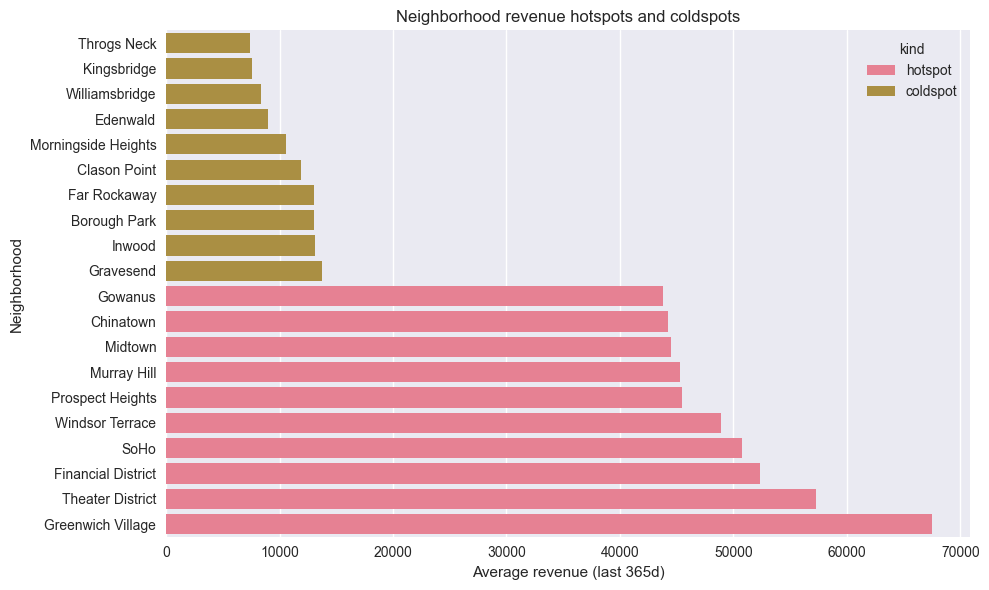

In [274]:
assert {"neighbourhood_cleansed", "avg_revenue"}.issubset(geo_filtered.columns)
rank_df = geo_filtered[["neighbourhood_cleansed", "avg_revenue", "listing_count", "avg_rating"]].copy()
rank_df["avg_revenue"] = pd.to_numeric(rank_df["avg_revenue"], errors="coerce")

k = min(10, len(rank_df))
top10_rev = rank_df.nlargest(k, "avg_revenue").assign(kind="hotspot")
bot10_rev = rank_df.nsmallest(k, "avg_revenue").assign(kind="coldspot")

plot_df = pd.concat([top10_rev, bot10_rev], ignore_index=True)

y_order = plot_df.sort_values("avg_revenue")["neighbourhood_cleansed"]

plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    x="avg_revenue",
    y="neighbourhood_cleansed",
    order=y_order,
    hue="kind"
)
plt.xlabel("Average revenue (last 365d)")
plt.ylabel("Neighborhood")
plt.title("Neighborhood revenue hotspots and coldspots")
plt.tight_layout()
plt.show()

## Conclusion

This analysis set out to answer two questions:  
1. What factors drive higher ratings or revenue for Airbnb listings?  
2. Do certain neighborhoods consistently outperform others?  

**Takeaways from Airbnb**  
- **Communication is central**. Host communication scores show the strongest link to ratings `(ρ ≈ 0.73)` and review sentiment `(ρ ≈ 0.47)`, underscoring that responsiveness drives guest satisfaction. This was one of the few strong correlations in the dataset.  
- **Recognition matters**. Superhost status correlates positively with both ratings and revenue `(ρ ≈ 0.22–0.28)`. While these are moderate correlations, they are consistent across outcomes, suggesting that Airbnb’s recognition system is a reliable quality signal.  
- **Hidden gems vs. expectations**. A hair dryer in Little Italy is a differentiator `(ρ ≈ 0.78, ~35% prevalence)`, while in the Theater District `(~95% prevalence)` it adds no value. Other features show moderate but meaningful correlations, like coffee makers in Ozone Park `(ρ ≈ 0.70)` or microwaves in Richmond Hill (`(ρ ≈ 0.59)`). These effects highlight that context shifts an amenity from hidden gem to baseline expectation.  
- **The revenue–quality paradox**. Review metrics show weak negative correlations with revenue `(-0.02 to -0.11)`. While not strong in magnitude, the consistency of these relationships suggests that high-revenue properties face tougher guest expectations or earn more due to location despite only average reviews.  
- **Hotspots and coldspots**. Greenwich Village, Theater District, and Financial District exceed `($50k)` average revenue and are statistical outliers, while Throgs Neck, Kingsbridge, Williamsbridge, Edenwald, and Morningside Heights consistently fall below `($11k)`. These patterns are large in scale, even if other neighborhood-to-neighborhood differences are modest.  

**How this relates to Warmer**  
These patterns translate into lessons for matching clients and experts:  
- **Communication is central → Responsiveness builds trust.** Just as Airbnb hosts succeed through strong communication, Warmer experts who are responsive and clear will likely drive better client outcomes.  
- **Recognition matters → Expert credibility matters.** Even moderate correlations `(ρ ≈ 0.22–0.28)` show that recognition (like Superhost) signals quality. At Warmer, consistent positive feedback, peer endorsement, or tenure could play the same role.  
- **Context matters in lived experience → Topic-specific expertise.** At Warmer, experts tag themselves with the areas they have lived experience in. For example, within caregiving, a client caring for a young child may need different guidance than a client caring for an elderly parent. Both experts are tagged under caregiving, but matching based on the closest context makes the support more relevant and impactful.
- **Revenue–quality paradox → Potential quantity vs. depth tradeoff.** On Airbnb, high revenue sometimes pairs with weaker reviews (`-0.02 to -0.11`), showing that scale does not always equal quality. At Warmer, the parallel could be explored at the topic level: categories with high engagement may not always deliver the strongest outcomes or feedback. Analyzing whether heavily used topics show similar satisfaction levels as less common ones would help ensure that growth in volume does not come at the expense of impact.
- **Neighborhood hotspots → Topic hotspots.** Just as some neighborhoods consistently outperform in Airbnb data, certain Warmer categories (such as caregiving, housing stability, or personal reinvention) already appear as popular topics on the website. Data analysis can validate which categories consistently drive higher engagement (topic hotspots), and also surface areas with persistently lower engagement (topic coldspots). This helps Warmer decide where to prioritize resources and where additional outreach or expert recruitment might be needed.